# Prompt and Response Construction Experiments

## Imports and setup

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
import sys
from pathlib import Path

# Add backend folder to Python path
backend_path = Path.cwd().parent  # Goes from nbs/ to backend/
sys.path.insert(0, str(backend_path))

In [4]:
from importlib import reload
import app.submodules
import importlib
import app.utils
import app.rag_utils
import app.submodules

/Users/oliviacheng/miniconda3/envs/cspnj/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/Users/oliviacheng/miniconda3/envs/cspnj/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [5]:
import time
from tqdm import tqdm

In [6]:
from app.submodules import construct_response

## Basic Example

In [7]:
TEXT = "I am located in Vineland, NJ off of Landis Avenue. Do you have information on the soup kitchens in Vineland? I want specific links and addresses"
PREVIOUS_TEXT = []
MODEL = "copilot"
ORG = "cspnj"

In [8]:
def generator_loop(text=TEXT, previous_text=PREVIOUS_TEXT):
    generator = construct_response(text, previous_text, MODEL, ORG)
    full_response = ""
    for chunk in generator:
        full_response += chunk.replace("\n\n","").replace("data: ","")
    formatted_response = full_response.replace("<br/>","\n")
    return formatted_response

## Note that each response is a fresh start in this experiment

In [ ]:
RUNS = 15
time_measurements_rerun = []
for _ in tqdm(range(RUNS)):
    start_time = time.time()
    response = generator_loop()
    time_measurements_rerun.append(time.time() - start_time)

In [10]:
print(time_measurements_rerun)

[46.25557899475098, 58.874048948287964, 28.645138263702393, 36.427218198776245, 25.024669885635376, 35.52994394302368, 23.551317930221558, 20.940498113632202, 49.56755495071411, 51.03378200531006, 30.668550968170166, 26.219016790390015, 27.825571060180664, 22.042134046554565, 37.44159817695618]


In [ ]:
%pip install matplotlib

In [13]:
from matplotlib import pyplot as plt

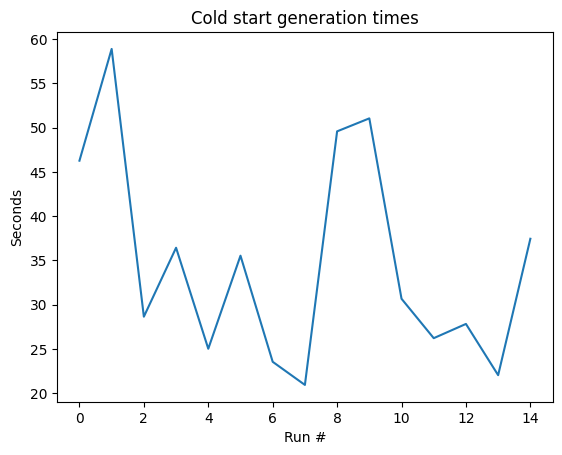

In [40]:
plt.plot(list(range(RUNS)), time_measurements_rerun)
plt.xlabel("Run #")
plt.ylabel("Seconds")
plt.title("Cold start generation times")
plt.show()

## In this experiment, generate outputs incorporating previous response.

In [ ]:
RUNS = 15
time_measurements_cont = []
responses=PREVIOUS_TEXT.copy()
for run_num in tqdm(range(RUNS)):
    if run_num == 0:
        text = TEXT
    else:
        text = "Please provide me with some more resources in nearby counties."
    start_time = time.time()
    response = generator_loop(text, responses)
    responses.append({"role": "user", "content": text})
    responses.append({"role": "assistant", "content": response})
    time_measurements_cont.append(time.time() - start_time)

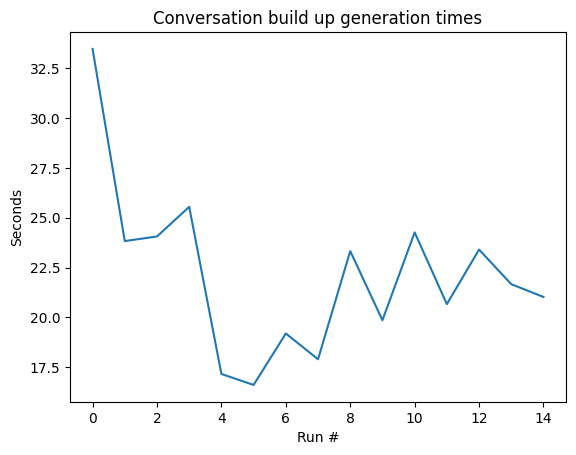

In [36]:
plt.plot(list(range(RUNS)), time_measurements_cont)
plt.xlabel("Run #")
plt.ylabel("Seconds")
plt.title("Conversation build up generation times")
plt.show()

## Now run with more granularity

In [21]:
reload(app.submodules)

<module 'app.submodules' from '/Users/oliviacheng/projects/research/community_services_llm/backend/app/submodules.py'>

In [25]:
import json
def generator_loop_granular(text=TEXT, previous_text=PREVIOUS_TEXT):
    generator = construct_response(text, previous_text, MODEL, ORG, track_time=True)
    full_response = ""
    timings = None
    
    for chunk in generator:
        if "<!--TIMINGS:" in chunk:
            # Extract timing data
            timing_json = chunk.split("<!--TIMINGS:")[1].split("-->")[0]
            timings = json.loads(timing_json)
        else:
            full_response += chunk.replace("\n\n","").replace("data: ","")
    
    formatted_response = full_response.replace("<br/>","\n")
    return formatted_response, timings

In [ ]:
RUNS=15
all_timings = []
for i in range(RUNS):
    start_time = time.time()
    response, timings = generator_loop_granular()
    time_measurements_rerun.append(time.time() - start_time)
    if timings:
        print(f"Run {i}: {timings}")
        all_timings.append(timings)

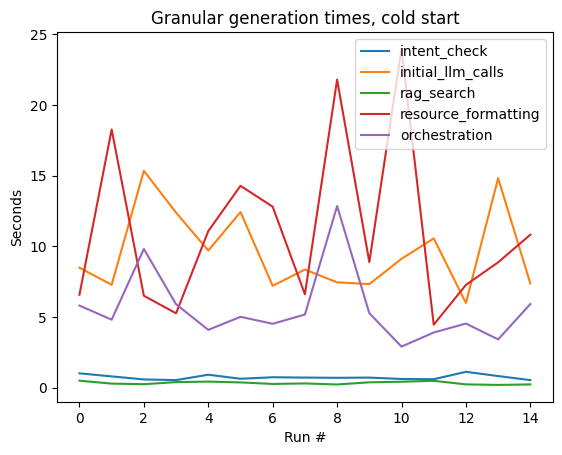

In [30]:
for key in all_timings[0].keys():
    if "total" in key:
        continue
    plt.plot(list(range(RUNS)), [all_timings[i][key] for i in range(RUNS)], label=key)
plt.legend()
plt.xlabel("Run #")
plt.ylabel("Seconds")
plt.title("Granular generation times, cold start")
plt.show()

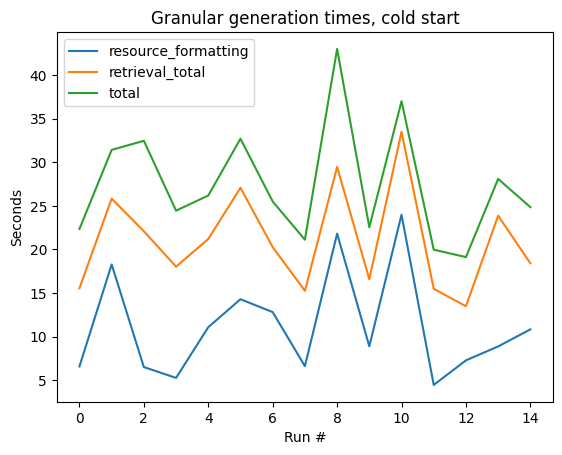

In [32]:
for key in all_timings[0].keys():
    if "total" not in key and "resource_formatting" not in key:
        continue
    plt.plot(list(range(RUNS)), [all_timings[i][key] for i in range(RUNS)], label=key)
plt.legend()
plt.xlabel("Run #")
plt.ylabel("Seconds")
plt.title("Granular generation times, cold start")
plt.show()

## Now run the granular test on a single conversation

In [ ]:
RUNS = 15
granular_time_measurements_cont = []
responses=PREVIOUS_TEXT.copy()
for run_num in tqdm(range(RUNS)):
    if run_num == 0:
        text = TEXT
    else:
        text = "Please provide me with some more resources in nearby counties."
    response, timings = generator_loop_granular(text, responses)
    
    responses.append({"role": "user", "content": text})
    responses.append({"role": "assistant", "content": response})
    if timings:
        print(f"Run {i}: {timings}")
        granular_time_measurements_cont.append(timings)

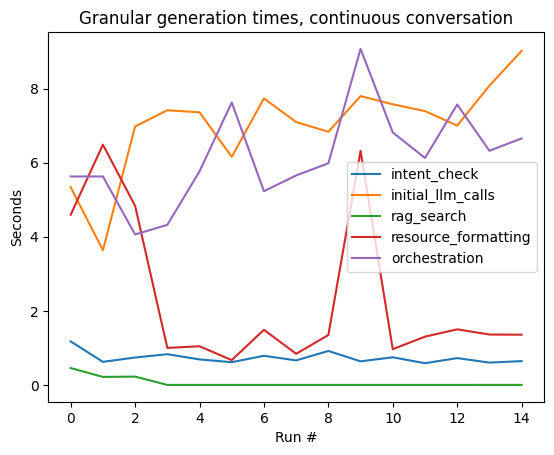

In [44]:
for key in granular_time_measurements_cont[0].keys():
    if "total" in key:
        continue
    plt.plot(list(range(RUNS)), [granular_time_measurements_cont[i][key] for i in range(RUNS)], label=key)
plt.legend()
plt.xlabel("Run #")
plt.ylabel("Seconds")
plt.title("Granular generation times, continuous conversation")
plt.show()

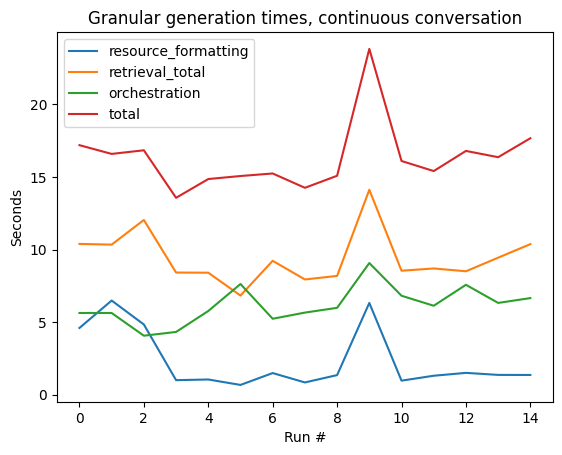

In [46]:
for key in granular_time_measurements_cont[0].keys():
    if "total" not in key and "resource_formatting" not in key and "orchestration" not in key:
        continue
    plt.plot(list(range(RUNS)), [granular_time_measurements_cont[i][key] for i in range(RUNS)], label=key)
plt.legend()
plt.xlabel("Run #")
plt.ylabel("Seconds")
plt.title("Granular generation times, continuous conversation")
plt.show()

## Summary of test:


1. Cold start time varies **widely** in between 20s and 60s.
2. Generation times appear to decrease after initial start as conversation gets longer before leveling off.
3. What takes the most time and is most correlated with spikes in overall latency in the **cold start** is **resource formatting**, i.e.:

```python
    all_resources = call_chatgpt_api_all_chats([{'role': 'system', 'content': 'You are a highly knowledgable system that assists {}, a peer support organization, with finding the correct resources. Out of this large list of resources, return a nicely formatted list, with phones/addresses (ONLY USE THE INFORMATION PROVIDED) of the most relevant and diverse resources for the following situation: {}'.format(organization,situation)},{'role': 'user', 'content': all_resources}], stream=False)
```

3. What takes the most time  the **continuous conversation** is **orchestration**.

### Suggestion:

Can we do the resource formatting prompt either at login/startup or cache it somehow?